# Introduction - Predicting Potential Hit Games on Steam


This project aims to predict whether a game on Steam has the potential to become a "hit" based on its features, tags, supported languages, operating systems, and other metadata.  
The analysis combines data analysis, data preprocessing, and machine learning modeling to identify the most influential factors in a game's success.

The dataset used in this project comes from Kaggle:  
[Best Selling Steam Games of All Time](https://www.kaggle.com/datasets/hbugrae/best-selling-steam-games-of-all-time/data)  
It is licensed under **CC BY-SA 4.0**: [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).

The workflow of this project includes:
- Data exploration and visualization to identify trends,
- Data preprocessing and feature engineering for machine learning,
- Building and evaluating predictive models,
- Comparing model results with insights from the data analysis.


In [25]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import sparse
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Data Loading and Visualization

In [2]:
# Load dataset
uploaded = files.upload()

Saving bestSelling_games_.csv to bestSelling_games_.csv


## Dataset description

The `bestSelling_games.csv` file contains detailed information about popular games on the Steam platform. Each row represents a single game, with various attributes including:

**Data from Steam**

- **game_name**: The official title of the game.  
- **reviews_like_rate**: The recommendation rate from user reviews on Steam (e.g., "95% of the 100 reviews are positive").  
- **all_reviews_number**: The total number of user reviews the game has received on Steam.  
- **release_date**: The official release date of the game on the Steam platform. This includes the initial release date for games in Early Access.  
- **developer**: The primary developer or studio behind the game.  
- **user_defined_tags**: A set of genres and categories assigned to the game by the Steam community (e.g., "RPG", "Open World", "Story Rich").  
- **supported_os**: A list of the operating systems the game officially supports (win, mac, linux).  
- **supported_languages**: A list of languages that the game supports for interface, audio, or subtitles.  
- **price**: The price of the game.  
  *Note: The currency is MENA - U.S. Dollar, a regional price for the Middle East & North Africa, not the standard USD. A value of 0 indicates the game is "Free to Play".*  
- **other_features**: A set of features defined by Steam under the "player support" category (e.g., "Single-player", "Online PvP", "Steam Achievements", "Family Sharing", "Online Co-op", "VR Supported").

**Data from GameFAQs & Steam Reviews**

- **age_restriction**: The recommended age restriction for the game's content, encoded as:  
  `0 = Everyone`, `10 = 10+`, `13 = 13+`, `17 = 17+`.  
- **rating**: An overall user-provided rating on a scale of 1 to 5 (1 = lowest, 5 = highest).  
- **difficulty**: Estimated difficulty of the game as perceived by players, on a scale of 1 (easiest) to 5 (hardest).  
- **length**: The average time (in hours) players spend to complete or fully experience the game.  
  *Note: Values are capped at 80 hours.*

**Data from SteamDB**

- **estimated_downloads**: The estimated total number of owners for the game.


In [3]:
filename = "bestSelling_games_.csv"
df = pd.read_csv(filename)
df.head()

,game_name,reviews_like_rate,all_reviews_number,release_date,developer,user_defined_tags,supported_os,supported_languages,price,other_features,age_restriction,rating,difficulty,length,estimated_downloads
0,Counter-Strike 2,86,8803754,"21 Aug, 2012",Valve,"FPS, Action, Tactical","win, linux","English, Czech, Danish, Dutch, Finnish, French...",0.00,"Cross-Platform Multiplayer, Steam Trading Card...",17,3.20,4,80,306170000
1,PUBG: BATTLEGROUNDS,59,2554482,"21 Dec, 2017",PUBG Corporation,"Survival, Shooter, Action, Tactical",win,"English, Korean, Simplified Chinese, French, G...",0.00,"Online PvP, Stats, Remote Play on Phone, Remot...",13,3.10,4,73,162350000
2,ELDEN RING NIGHTREIGN,77,53426,"30 May, 2025","FromSoftware, Inc.","Souls-like, Open World, Fantasy, RPG",win,"English, Japanese, French, Italian, German, Sp...",25.99,"Single-player, Online Co-op, Steam Achievement...",17,3.96,4,50,840000
3,The Last of Us™ Part I,79,45424,"28 Mar, 2023",Naughty Dog LLC,"Story Rich, Shooter, Survival, Horror",win,"English, Italian, Spanish - Spain, Czech, Dutc...",59.99,"Single-player, Steam Achievements, Steam Tradi...",17,4.10,3,24,2000000
4,Red Dead Redemption 2,92,672140,"5 Dec, 2019",Rockstar Games,"Open World, Story Rich, Adventure, Realistic, ...",win,"English, French, Italian, German, Spanish - Sp...",59.99,"Single-player, Online PvP, Online Co-op, Steam...",17,4.32,3,80,21610000


## Missing values heatmap

The heatmap shows missing values in the dataset. Each column is a feature, and each row is a game.  
Since the heatmap is fully colored with no gaps, it means **there are no missing values**.  
The dataset is clean and ready for further analysis.

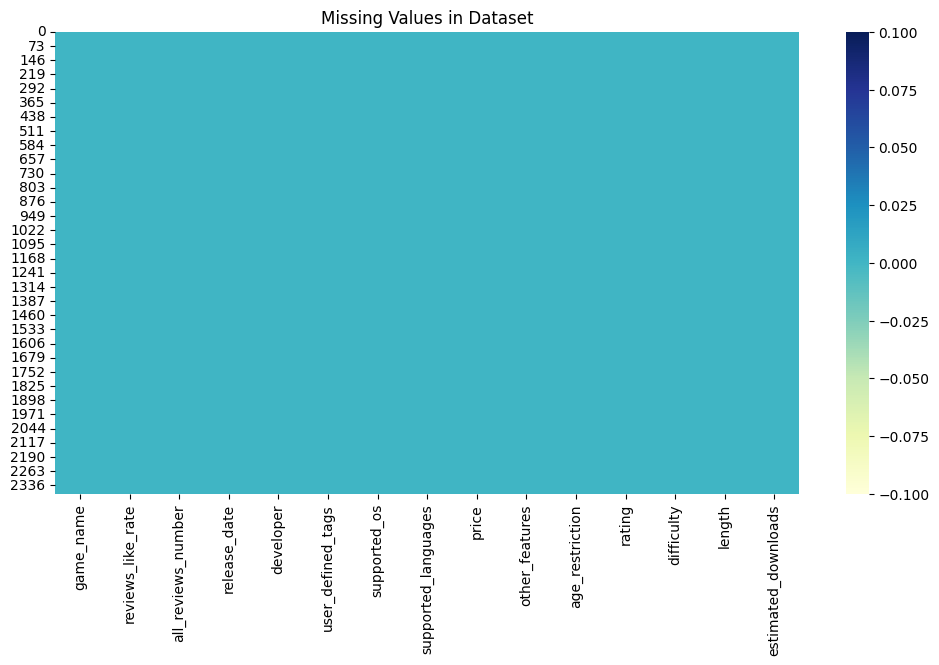

In [4]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='YlGnBu')
plt.title("Missing Values in Dataset")
plt.show()

## Top 10 Most Popular Games by Estimated Downloads

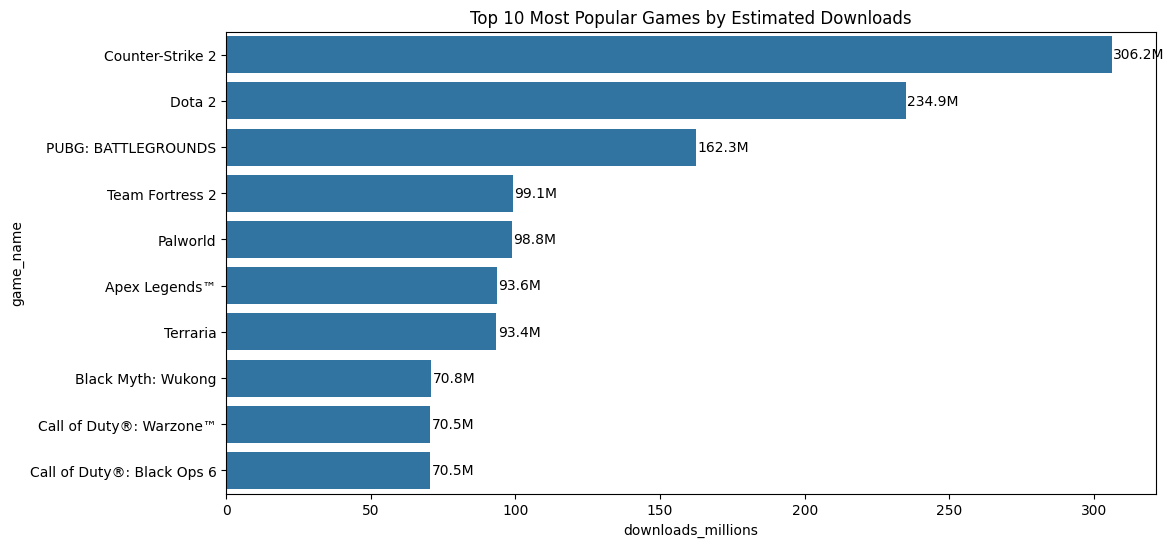

In [5]:
# Sort by estimated_downloads and take top 10
top_games = df.sort_values(by='estimated_downloads', ascending=False).head(10)

# Convert to millions for better readability
top_games['downloads_millions'] = top_games['estimated_downloads'] / 1_000_000

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='downloads_millions', y='game_name', data=top_games)
plt.title("Top 10 Most Popular Games by Estimated Downloads")

# Add value labels on bars
for i, val in enumerate(top_games['downloads_millions']):
    ax.text(val + 0.5, i, f'{val:.1f}M', va='center')

plt.show()

## Analyze Feature Impact on Game Popularity

## Numeric Features



### Correlation of Numeric Features with Estimated Downloads

The chart shows the Pearson correlation between numeric features and the estimated number of downloads.  
The **number of all reviews** has the strongest positive correlation (~0.88), followed by **game length** and **rating**.  
Other features like difficulty, age restriction, price, and reviews like rate show weaker correlations with downloads.


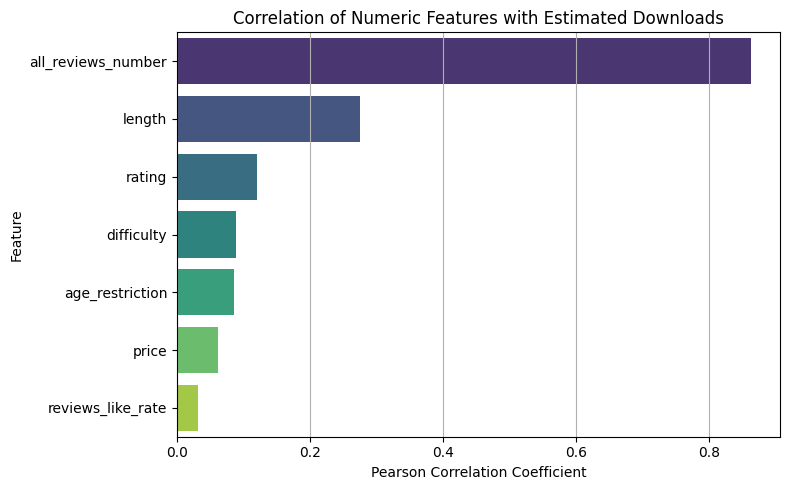

In [6]:
# Select numeric features including the target variable
numeric_features = [
    'reviews_like_rate',
    'all_reviews_number',
    'price',
    'age_restriction',
    'rating',
    'difficulty',
    'length',
    'estimated_downloads'
]

# Calculate correlation with 'estimated_downloads' only
correlation = df[numeric_features].corr(numeric_only=True)['estimated_downloads'].drop('estimated_downloads')
correlation = correlation.sort_values(ascending=False)

# Barplot of correlation values
plt.figure(figsize=(8, 5))
sns.barplot(x=correlation.values, y=correlation.index, hue=correlation.index, legend=False, palette='viridis')
plt.title('Correlation of Numeric Features with Estimated Downloads')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## Non-Numeric Features

### Distribution of Estimated Downloads per Developer (Top 10)

The chart shows the distribution of estimated downloads for the top 10 developers.  
**Valve** stands out with the highest median downloads and the widest range, followed by developers like **Arc System Works** and **Bethesda Game Studios**.  
Some developers have narrower distributions, indicating more consistent download numbers across their games.


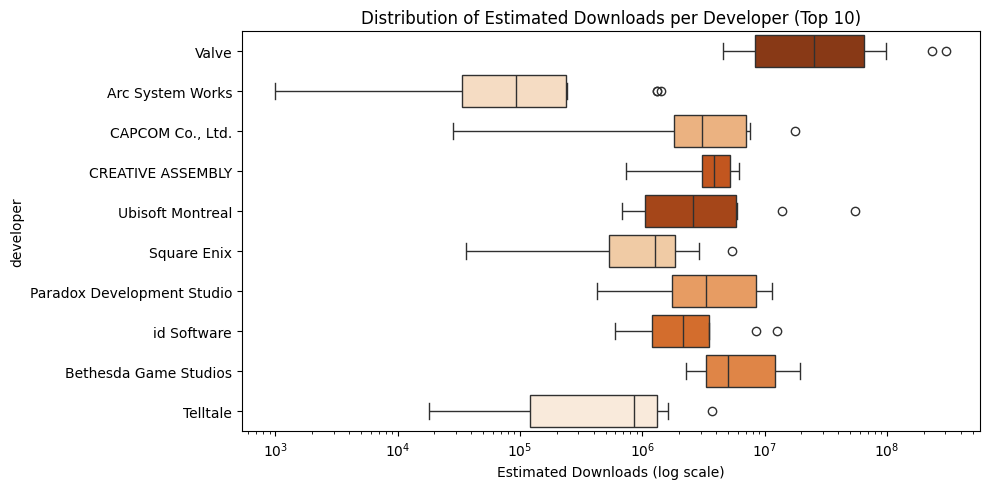

In [7]:
# Developer vs Estimated Downloads -> Boxplot

# Get top 10 most frequent developers
top_devs = df['developer'].value_counts().head(10).index

# Filter dataset to only include games from top developers
df_top_devs = df[df['developer'].isin(top_devs)].copy()

# Plot boxplot of estimated downloads per developer
plt.figure(figsize=(10, 5))
sns.boxplot(y='developer', x='estimated_downloads', data=df_top_devs,
            order=top_devs, hue='developer', palette='Oranges_r', legend=False)

plt.xscale('log')  # Use log scale for better visibility
plt.xlabel("Estimated Downloads (log scale)")
plt.title("Distribution of Estimated Downloads per Developer (Top 10)")
plt.tight_layout()
plt.show()

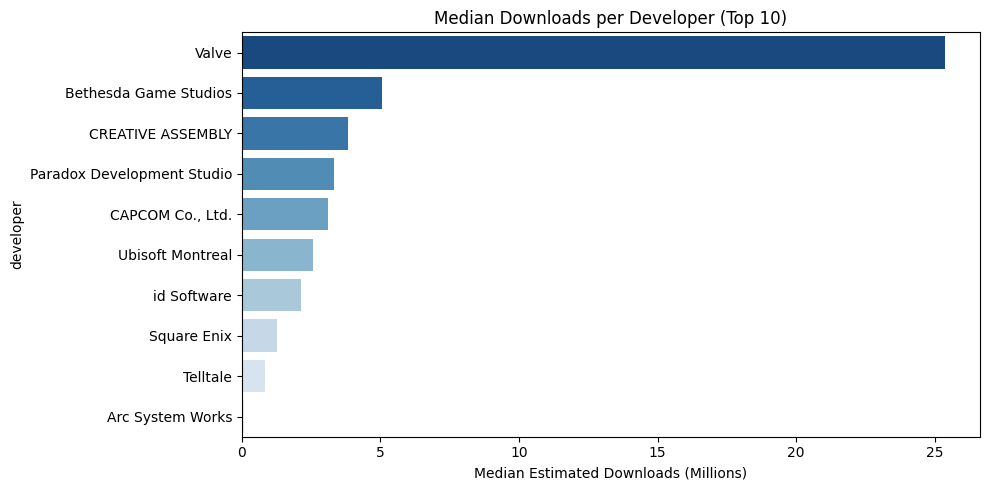

In [8]:
# Developer vs Estimated Downloads -> Median

# Median estimated downloads per developer (converted to millions)
dev_median = df_top_devs.groupby('developer')['estimated_downloads'].median().sort_values(ascending=False) / 1_000_000

# Plot median Downloads
plt.figure(figsize=(10, 5))
sns.barplot(x=dev_median.values, y=dev_median.index, hue=dev_median.index, palette='Blues_r')
plt.xlabel("Median Estimated Downloads (Millions)")
plt.title("Median Downloads per Developer (Top 10)")
plt.tight_layout()
plt.show()

### Distribution of Estimated Downloads by Supported OS

The chart compares estimated downloads for games based on their supported operating systems.  
Games available on **Linux** show the highest median downloads, followed by **Mac** and **Windows**.  
However, Windows has the widest range of downloads, reflecting the large variety of games available on this platform.


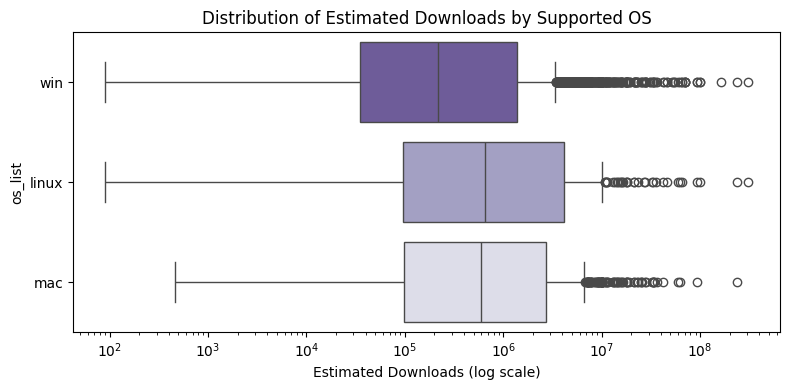

In [9]:
# Supported OS vs Estimated Downloads -> Boxplot

valid_os = ['win', 'mac', 'linux']

# Convert 'supported_os' column to list and explode
df['os_list'] = df['supported_os'].dropna().apply(lambda x: [os.strip() for os in x.split(',')])
df_os = df.explode('os_list')

# Filter only valid operating systems
df_os = df_os[df_os['os_list'].isin(valid_os)]

# Plot boxplot of downloads per supported OS
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_os, x='estimated_downloads', y='os_list', hue='os_list', palette='Purples_r', legend=False)
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Estimated Downloads (log scale)")
plt.title("Distribution of Estimated Downloads by Supported OS")
plt.tight_layout()
plt.show()

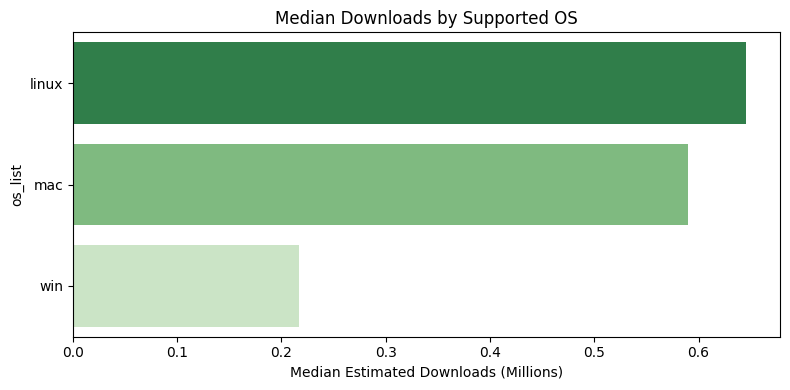

In [33]:
# Supported OS vs Estimated Downloads -> Median

# Calculate median downloads per OS (in millions)
os_median = df_os.groupby('os_list')['estimated_downloads'].median().sort_values(ascending=False) / 1_000_000

# Plot median downloads
plt.figure(figsize=(8, 4))
sns.barplot(x=os_median.values, y=os_median.index, hue=os_median.index, palette='Greens_r')
plt.xlabel("Median Estimated Downloads (Millions)")
plt.title("Median Downloads by Supported OS")
plt.tight_layout()
plt.show()

### Distribution of Estimated Downloads by Tag (Top 10)

This chart compares the estimated downloads for the most popular game tags.  
**FPS** has the highest median downloads, showing that shooters often perform well.  
**Action**, **Survival**, and **Open World** also have high medians and a wide range of results, meaning these genres include both average games and big hits.  
Genres like **Adventure**, **Strategy**, and **2D** have lower medians, but some titles still reach very high download numbers, shown by the many outliers.


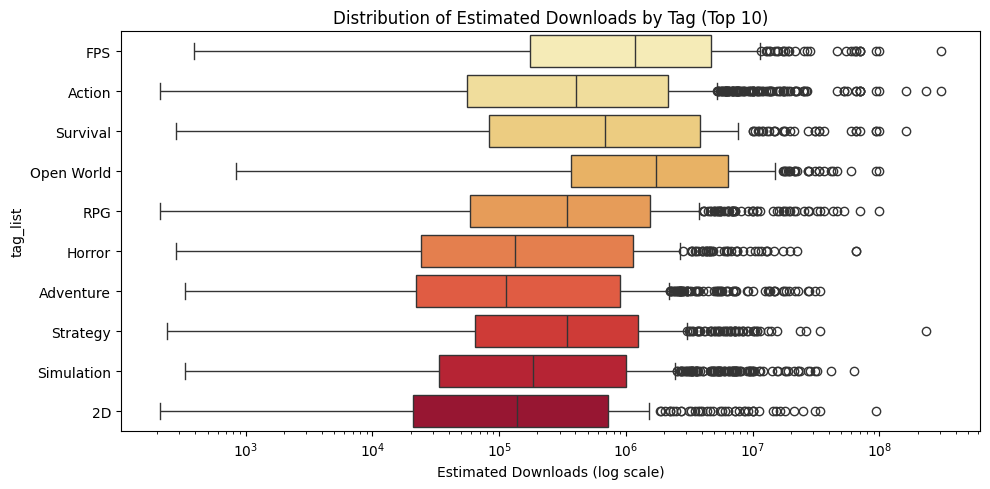

In [11]:
# Tags vs Estimated Downloads -> Boxplot

# Convert 'user_defined_tags' to list format
df['tag_list'] = df['user_defined_tags'].dropna().apply(lambda x: [tag.strip() for tag in x.split(',')])
df_tags = df.explode('tag_list')

# Get top 10 most common tags
top_tags = [tag for tag, _ in Counter(df_tags['tag_list']).most_common(10)]
df_top_tags = df_tags[df_tags['tag_list'].isin(top_tags)]

# Plot boxplot of estimated downloads per tag
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_top_tags, x='estimated_downloads', y='tag_list', hue='tag_list', palette='YlOrRd', legend=False)
plt.xscale('log')  # Log scale to handle variation
plt.xlabel("Estimated Downloads (log scale)")
plt.title("Distribution of Estimated Downloads by Tag (Top 10)")
plt.tight_layout()
plt.show()

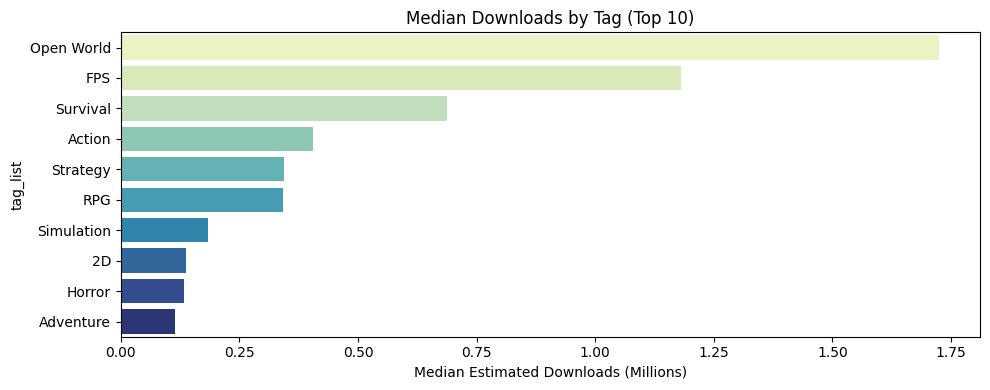

In [12]:
# Tags vs Estimated Downloads -> Median

# Compute median downloads per tag (in millions)
tag_median = df_top_tags.groupby('tag_list')['estimated_downloads'].median().sort_values(ascending=False) / 1_000_000

# Plot median downloads
plt.figure(figsize=(10, 4))
sns.barplot(x=tag_median.values, y=tag_median.index, hue=tag_median.index, palette='YlGnBu')
plt.xlabel("Median Estimated Downloads (Millions)")
plt.title("Median Downloads by Tag (Top 10)")
plt.tight_layout()
plt.show()

### Distribution of Estimated Downloads by Supported Language (Top 10)

This chart shows estimated downloads for the top 10 supported languages.  
**English** has the highest median downloads, suggesting that games in English often reach larger audiences.  
Other languages like **French**, **German**, and **Italian** have similar medians, with many high-performing titles as shown by the outliers.  
Languages such as **Spanish (Spain)** and **Simplified Chinese** have slightly lower medians but still include several very popular games.


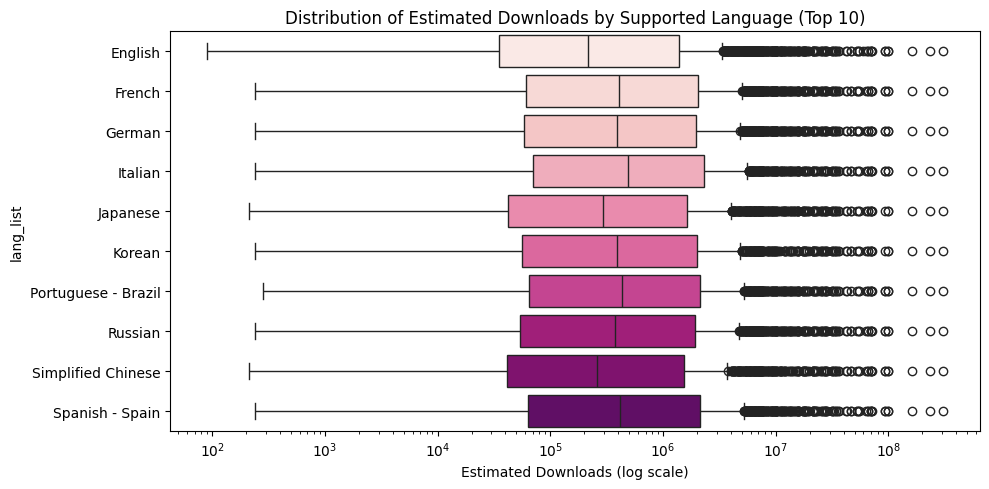

In [13]:
# Supported Languages vs Estimated Downloads -> Boxplot

# Convert 'supported_languages' to list format
df['lang_list'] = df['supported_languages'].dropna().apply(lambda x: [lang.strip() for lang in x.split(',')])
df_lang = df.explode('lang_list')

# Get top 10 most common languages
top_langs = [lang for lang, _ in Counter(df_lang['lang_list']).most_common(10)]
df_top_langs = df_lang[df_lang['lang_list'].isin(top_langs)]

# Plot boxplot of estimated downloads per language
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_top_langs, x='estimated_downloads', y='lang_list', hue='lang_list', palette='RdPu', legend=False)
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Estimated Downloads (log scale)")
plt.title("Distribution of Estimated Downloads by Supported Language (Top 10)")
plt.tight_layout()
plt.show()

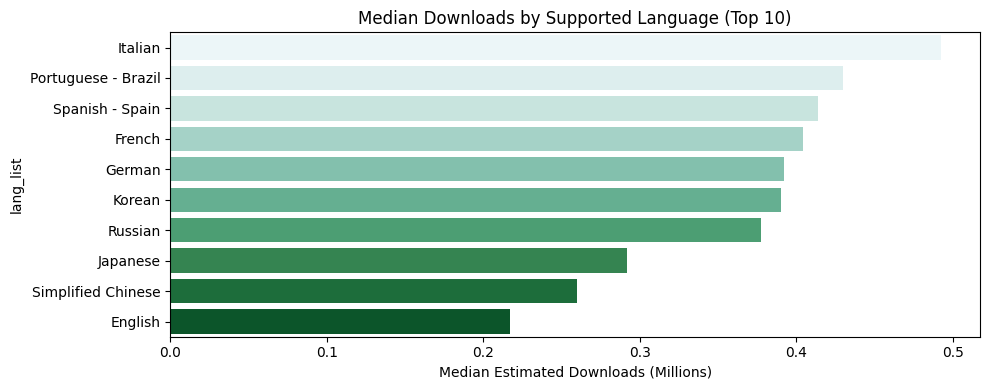

In [14]:
# Supported Languages vs Estimated Downloads -> Median

# Compute median downloads per language (in millions)
lang_median = df_top_langs.groupby('lang_list')['estimated_downloads'].median().sort_values(ascending=False) / 1_000_000

# Plot median Downloads
plt.figure(figsize=(10, 4))
sns.barplot(x=lang_median.values, y=lang_median.index, hue=lang_median.index, palette='BuGn')
plt.xlabel("Median Estimated Downloads (Millions)")
plt.title("Median Downloads by Supported Language (Top 10)")
plt.tight_layout()
plt.show()

### Distribution of Estimated Downloads by Game Feature (Top 10)

This chart shows the distribution of estimated downloads for the top 10 game features.  
Features like **Steam Trading Cards**, **Steam Workshop**, and **In-App Purchases** are associated with a wide range of download counts, often including many high-performing games.  
Modes such as **Online PvP** and **Online Co-op** also appear in popular titles, indicating their potential appeal to players.


/tmp/ipython-input-1356023354.py:15: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df_top_features, x='estimated_downloads', y='features_list', scale='width', inner='quartile')


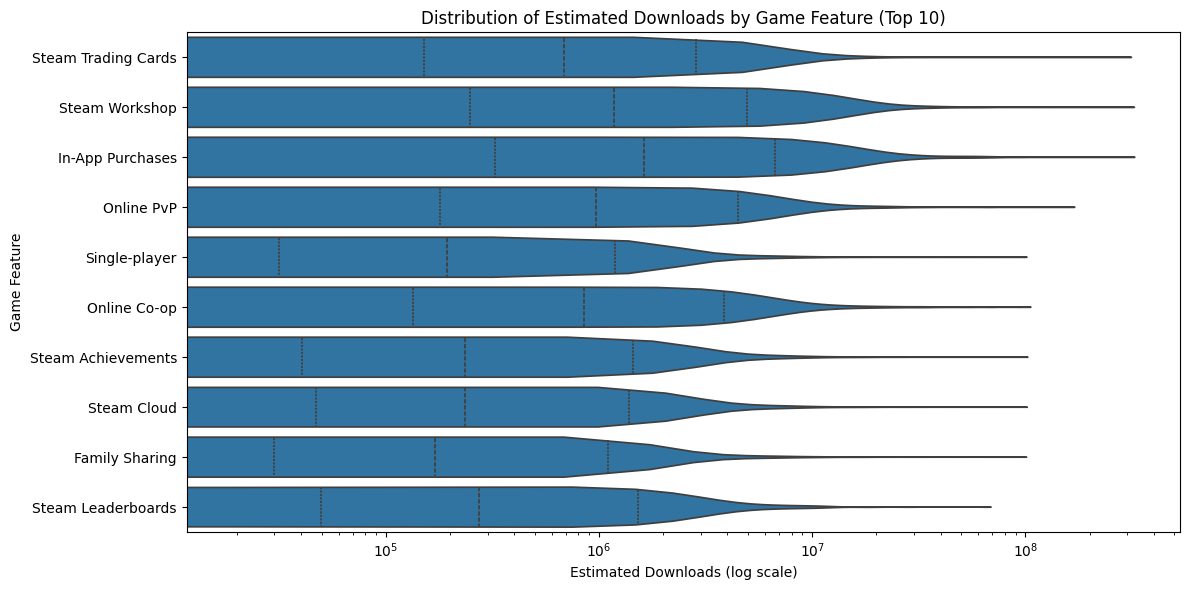

In [15]:
# Other Features vs Estimated Downloads -> Violin Plot

# Convert 'other_features' to list
df['features_list'] = df['other_features'].dropna().apply(lambda x: [feature.strip() for feature in x.split(',')])

# Explode list into rows
df_features = df.explode('features_list')

# Filter top 10 most common features
top_features = [f for f, _ in Counter(df_features['features_list']).most_common(10)]
df_top_features = df_features[df_features['features_list'].isin(top_features)]

# Plot violin plot on log scale
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_top_features, x='estimated_downloads', y='features_list', scale='width', inner='quartile')
plt.xscale('log')
plt.xlabel('Estimated Downloads (log scale)')
plt.ylabel('Game Feature')
plt.title('Distribution of Estimated Downloads by Game Feature (Top 10)')
plt.tight_layout()
plt.show()

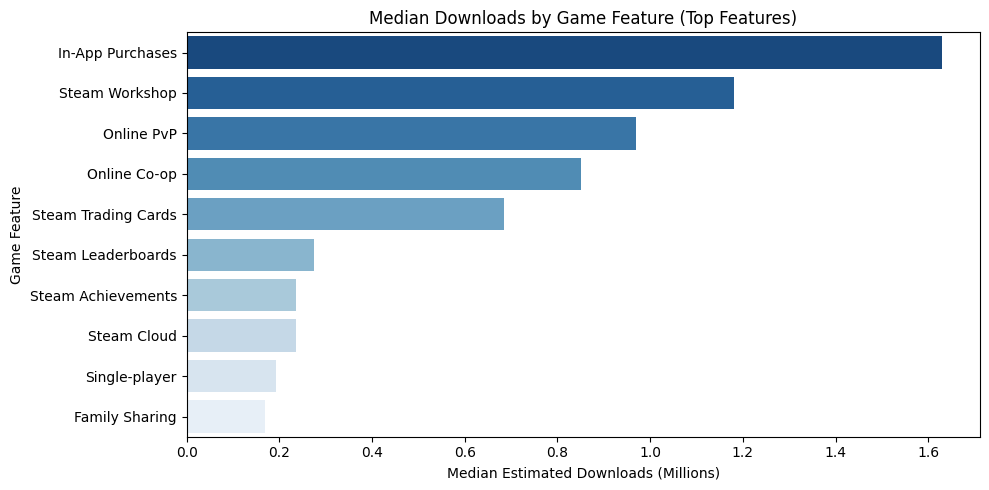

In [16]:
# Other Features vs Estimated Downloads -> Median

# Calculate median downloads per feature
feature_medians = df_top_features.groupby('features_list')['estimated_downloads'].median().sort_values(ascending=False) / 1_000_000  # convert to millions

# Plot median
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_medians.values, y=feature_medians.index, hue=feature_medians.index, palette='Blues_r')
plt.xlabel("Median Estimated Downloads (Millions)")
plt.ylabel("Game Feature")
plt.title("Median Downloads by Game Feature (Top Features)")
plt.tight_layout()
plt.show()

# Data Preprocessing

In this step, we prepare the raw dataset for modeling.  
The goal is to ensure that all features are numeric and that the model can learn from both numeric values and categorical information such as tags, supported languages, operating systems, and other features.

Steps:
1. Extract `release_year` from `release_date`.
2. Create the binary target variable `hit` based on the top 20% of games by `estimated_downloads`.
3. Keep numeric features and standardize them with `StandardScaler`.
4. Convert the developer column into numeric format using one-hot encoding.
5. Split multi-valued columns (`user_defined_tags`, `supported_languages`, `supported_os`, `other_features`) into individual items and apply multi-hot encoding so that each tag, language, or feature gets its own binary column.
6. Combine all processed features into a single numeric matrix ready for machine learning models.


In [17]:
# Extract release year
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_year"] = df["release_date"].dt.year

# Create binary target 'hit'
threshold = df["estimated_downloads"].quantile(0.80)
df["hit"] = (df["estimated_downloads"] >= threshold).astype(int)

# Numeric and multi-label columns
numeric_features = [
    "reviews_like_rate", "all_reviews_number", "price",
    "age_restriction", "rating", "difficulty", "length", "release_year"
]

multi_label_features = [
    "user_defined_tags", "supported_os", "supported_languages", "other_features"
]

single_cat_features = ["developer"]

In [18]:
# Function to split comma-separated strings into lists
def split_and_strip(series):
    return series.fillna("").apply(lambda x: [item.strip() for item in x.split(",") if item.strip()])

# Apply split to all multi-label columns
for col in multi_label_features:
    df[col] = split_and_strip(df[col])

# Prepare MultiLabelBinarizers for each multi-label column
mlb_encoders = {}
for col in multi_label_features:
    mlb = MultiLabelBinarizer()
    mlb_encoders[col] = mlb
    encoded = pd.DataFrame(
        mlb.fit_transform(df[col]),
        columns=[f"{col}__{cls}" for cls in mlb.classes_],
        index=df.index
    )
    df = pd.concat([df, encoded], axis=1)

# Final feature list (numeric + multi-hot columns + developer)
multi_hot_columns = [c for c in df.columns if "__" in c]  # all generated binary tag columns
final_features = numeric_features + single_cat_features + multi_hot_columns


In [19]:
# Train/test split
X = df[final_features]
y = df["hit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing: scale numeric, one-hot for single categories, pass multi-hot as is
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, single_cat_features),
        ("multi", "passthrough", multi_hot_columns)
    ]
)

In [20]:
# Transform the data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

print("X_train_prepared shape:", X_train_prepared.shape)
print("X_test_prepared shape:", X_test_prepared.shape)

X_train_prepared shape: (1904, 1691)
X_test_prepared shape: (476, 1691)


In [21]:
# Get column names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Convert sparse -> dense for inspection
if sparse.issparse(X_train_prepared):
    X_dense = X_train_prepared.toarray()
else:
    X_dense = X_train_prepared

# Create DataFrame with column names
X_df = pd.DataFrame(X_dense, columns=feature_names)

# Check basic info
print("Data types:", X_df.dtypes.unique())
print("All numeric and finite?", np.isfinite(X_df.to_numpy()).all())
print("Shape:", X_df.shape)

# Show first rows
X_df.head(10)

Data types: [dtype('float64')]
All numeric and finite? True
Shape: (1904, 1691)


,num__reviews_like_rate,num__all_reviews_number,num__price,num__age_restriction,num__rating,num__difficulty,num__length,num__release_year,cat__developer_10 Games,cat__developer_100 Cats,...,multi__other_features__Steam Cloud,multi__other_features__Steam Leaderboards,multi__other_features__Steam Timeline,multi__other_features__Steam Trading Cards,multi__other_features__Steam Turn Notifications,multi__other_features__Steam Workshop,multi__other_features__SteamVR Collectibles,multi__other_features__Tracked Controller Support,multi__other_features__VR Only,multi__other_features__VR Supported
0,0.908560,-0.055597,-0.053082,0.999787,0.603754,0.134360,-0.609867,-1.533253,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.288803,-0.135524,-0.699294,0.999787,0.423320,0.134360,-0.515115,0.950389,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.288803,0.019067,-0.285718,-0.097747,0.358879,0.134360,0.053398,0.743419,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.485895,-0.137916,-0.742375,0.999787,-1.342361,-0.901353,-0.941500,0.122508,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.908560,-0.134080,-0.656213,0.372625,0.977512,0.134360,-0.278235,-2.775074,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-1.725410,-0.138620,-0.801826,0.999787,-2.128540,-0.901353,-0.799371,0.329478,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.366272,-0.137492,-0.742375,-1.665653,1.041953,0.134360,-0.894124,0.950389,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-1.880349,-0.138214,-0.913836,0.372625,-1.948105,1.170073,-0.704619,0.536448,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.288803,-0.138507,-0.785456,0.372625,-1.754783,-0.901353,-1.036252,0.950389,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.753621,0.389508,-0.010001,-1.665653,1.067729,1.170073,1.332551,-1.326283,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Models

In this section, we train and compare two classification models to predict whether a game has the potential to become a hit.

- **Logistic Regression (baseline)**: A simple, interpretable linear model that works well with preprocessed numerical data and one-hot encoded features.
- **LightGBM**: A gradient boosting algorithm optimized for speed and performance on tabular datasets, capable of capturing non-linear relationships and feature interactions.

We will:
1. Train both models using the same preprocessed dataset.
2. Evaluate their performance using metrics such as Accuracy, Precision, Recall, F1 score, and ROC AUC.
3. Compare results in a summary table.


In [27]:
# Logistic Regression -> baseline model

# Create Logistic Regression model
"""
penalty="l2" -> standard regularization to prevent overfitting
solver="liblinear" -> optimization algorithm used to find the best model weights.
   liblinear is a good choice when:
   - The dataset is not extremely large (fits in memory comfortably)
   - The data is sparse (contains many zeros), e.g., after one-hot encoding
   It is reliable for binary classification and L2 regularization,
   though it may be slower on very large datasets.
max_iter=1000 -> increase to ensure convergence
"""

log_reg = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
    random_state=42
)

# Train the model on the prepared training data
log_reg.fit(X_train_prepared, y_train)

# Predict probabilities for the positive class (hit=1)
y_prob_logreg = log_reg.predict_proba(X_test_prepared)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_logreg = (y_prob_logreg >= 0.5).astype(int)

# Print evaluation metrics for Logistic Regression
print("Logistic Regression — metrics")
print("Accuracy :", accuracy_score(y_test, y_pred_logreg))
print("Precision:", precision_score(y_test, y_pred_logreg))
print("Recall   :", recall_score(y_test, y_pred_logreg))
print("F1       :", f1_score(y_test, y_pred_logreg))
print("ROC AUC  :", roc_auc_score(y_test, y_prob_logreg))

Logistic Regression — metrics
Accuracy : 0.9201680672268907
Precision: 0.8518518518518519
Recall   : 0.7263157894736842
F1       : 0.7840909090909091
ROC AUC  : 0.9588893493576461


In [30]:
# Create LightGBM model
"""
n_estimators=400 -> number of boosting rounds
learning_rate=0.05 -> smaller value for better generalization
random_state=42 -> reproducibility
"""
lgb_model = lgb.LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    random_state=42
)

# Train the LightGBM model
lgb_model.fit(X_train_prepared, y_train)

# Convert sparse test set to DataFrame with feature names
X_test_df = pd.DataFrame.sparse.from_spmatrix(
    X_test_prepared,
    columns=preprocessor.get_feature_names_out()
)

# Predict probabilities for the positive class (hit = 1)
y_prob_lgb = lgb_model.predict_proba(X_test_df)[:, 1]

# Convert probabilities to binary predictions using threshold 0.5
y_pred_lgb = (y_prob_lgb >= 0.5).astype(int)

# Print evaluation metrics for LightGBM
print("LightGBM — metrics")
print("Accuracy :", accuracy_score(y_test, y_pred_lgb))
print("Precision:", precision_score(y_test, y_pred_lgb))
print("Recall   :", recall_score(y_test, y_pred_lgb))
print("F1       :", f1_score(y_test, y_pred_lgb))
print("ROC AUC  :", roc_auc_score(y_test, y_prob_lgb))

[LightGBM] [Info] Number of positive: 382, number of negative: 1522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200630 -> initscore=-1.382360
[LightGBM] [Info] Start training from score -1.382360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM — metrics
Accuracy : 0.9600840336134454
Precision: 0.8958333333333334
Recall   : 0.9052631578947369
F1       : 0.900523560209424
ROC AUC  : 0.9922088686282635


## Side-by-side comparison

In [31]:
# Helper function to collect metrics for both models
def summarize(name, y_true, y_pred, y_prob):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_prob)
    }

# Create a summary DataFrame
summary = pd.DataFrame([
    summarize("Logistic Regression", y_test, y_pred_logreg, y_prob_logreg),
    summarize("LightGBM", y_test, y_pred_lgb, y_prob_lgb),
]).set_index("Model")

# Display the summary table
display(summary)


,Accuracy,Precision,Recall,F1,ROC AUC
Model,,,,,
Logistic Regression,0.920168,0.851852,0.726316,0.784091,0.958889
LightGBM,0.960084,0.895833,0.905263,0.900524,0.992209


In [32]:
# Inspect top features from LightGBM

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Get feature importances from the LightGBM model
importances = lgb_model.feature_importances_

# Get indices of the top 15 most important features
top_idx = np.argsort(importances)[-15:][::-1]

# Print feature names and importance scores
print("\nTop features (LightGBM):")
for i in top_idx:
    print(f"{feature_names[i]:60s}  {importances[i]}")


Top features (LightGBM):
num__all_reviews_number                                       2041
num__rating                                                   1141
num__length                                                   1076
num__release_year                                             1072
num__reviews_like_rate                                        968
num__price                                                    711
num__age_restriction                                          279
num__difficulty                                               268
multi__user_defined_tags__Action                              154
multi__supported_languages__Spanish - Spain                   152
multi__other_features__Steam Trading Cards                    128
multi__other_features__Online Co-op                           125
multi__supported_os__linux                                    118
multi__supported_languages__Spanish - Latin America           114
multi__supported_languages__Czech             

## Model Comparison Summary

Two models were tested to predict whether a game has the potential to become a hit: **Logistic Regression** and **LightGBM**.

- **LightGBM** achieved the best overall performance with an **accuracy of 96%**, **precision of 89.6%**, **recall of 90.5%**, **F1 score of 90.05%**, and an exceptionally high **ROC AUC of 0.992**. This means LightGBM is very good at distinguishing between hit and non-hit games and balances precision and recall well.

- **Logistic Regression** also performed strongly, with an **accuracy of 92%**, **precision of 85.2%**, **recall of 72.6%**, **F1 score of 78.4%**, and **ROC AUC of 0.959**. While slightly less accurate than LightGBM, it still provided solid predictions with a simpler, more interpretable model.

**Conclusion:**  
LightGBM is the better choice for this dataset in terms of predictive power, but Logistic Regression remains a good option when model simplicity and interpretability are priorities.
